# ReLu ResNets Singular points
Characterizing ResNets with 2d input and no bottle neck
How is the necessary singular point realized?

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.colors import to_rgb
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
# Model Params
num_hidden = 5 # number of hidden layers. The total network has additionl 2 layers: input to hidden + hidden to output
input_dim = 2
hidden_dim = 2
output_dim = 2
activation = 'relu'


#load or train
# load_path = 'resnet_5_CE' #set to False for training
# load_path = 'resnet_7_MSE'
load_path = 'last'
# load_path = False

# Training Params
cross_entropy = False #MSE loss leads to worse results for the architecture with 5 layers. at the moment the fewer layers the better thats why CE is chosen
num_epochs = 400

705


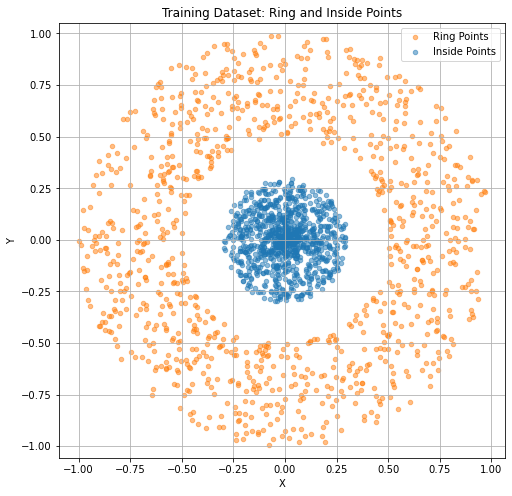

In [58]:

# Generate training data
seed = np.random.randint(1000)
print(seed)
np.random.seed(seed)
torch.manual_seed(seed)
n_points = 1000
inner_radius = 0.5
outer_radius = 1
buffer = 0.2

# Points on ring
angles_ring = np.random.uniform(0, 2 * np.pi, n_points)
radius_ring = np.random.uniform(inner_radius, outer_radius, n_points)
x_ring = radius_ring * np.cos(angles_ring)
y_ring = radius_ring * np.sin(angles_ring)
ring_points = np.stack((x_ring, y_ring), axis=1)

# Points inside ring
angles_inside = np.random.uniform(0, 2 * np.pi, n_points)
radius_inside = inner_radius * np.sqrt(np.random.uniform(0, 1, n_points))
x_inside = (radius_inside-buffer) * np.cos(angles_inside)
y_inside = (radius_inside-buffer) * np.sin(angles_inside)
inside_points = np.stack((x_inside, y_inside), axis=1)

# Labels
if cross_entropy:
    labels_ring = np.ones((n_points, 1))
    labels_inside = np.zeros((n_points, 1))    
else:
    labels_ring = np.tile([1, 0], (n_points, 1))
    labels_inside = np.tile([-1, 0], (n_points, 1))

# Combine data
data = np.vstack((ring_points, inside_points))
labels = np.vstack((labels_ring, labels_inside))

# Convert to tensors
data_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(data_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)

# Plot the data
plt.figure(figsize=(8, 8))
plt.scatter(ring_points[:, 0], ring_points[:, 1], s=20, c='C1', alpha = 0.5, label='Ring Points')
plt.scatter(inside_points[:, 0], inside_points[:, 1], s=20, c='C0', alpha = 0.5, label='Inside Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Training Dataset: Ring and Inside Points')
plt.axis('equal')
plt.grid(True)

In [59]:
for input, label in dataloader:
    print(input[:5], label[:5])
    break

tensor([[ 0.0089,  0.5176],
        [-0.2400, -0.5293],
        [ 0.0189,  0.0164],
        [-0.1631,  0.8287],
        [-0.1952, -0.8424]]) tensor([[ 1.,  0.],
        [ 1.,  0.],
        [-1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]])


# Initialize model, optimizer, and loss function


In [60]:
class ResidualBlock(nn.Module):
    def __init__(self, features, activation = 'relu'):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(features, features)
        if activation == 'relu':
            self.activation = nn.ReLU()
        if activation == 'tanh':
            self.activation = nn.Tanh()

    def forward(self, x):
        identity = x #cont here
        out = self.fc(x)
        out = self.activation(out)
        out = out + identity
        return out

class ResNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden, output_layer = True, activation = 'relu'):
        super(ResNet, self).__init__()
        self.num_hidden = num_hidden
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        if activation == 'relu':
            self.activation = nn.ReLU()
        if activation == 'tanh':
            self.activation = nn.Tanh()
            
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(hidden_dim, activation = activation) for _ in range(num_hidden)]
        )
        self.output_fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, output_layer = True):
        x = self.activation(self.input_fc(x))
        x = self.res_blocks(x)
        if output_layer:
            x = self.output_fc(x)
        return x
    
    '''
    sub_model is used to access a partial network of the input to output network
    layers are counted from 0 (input to hidden dim) until nth layer ( (n-1)th hidden layer to output layer)
    from_layer is the starting layer that is included in the sub_model
    to_layer is the final layer included in the sub_model
    e.g. from_layer = 1, to_layer = 2 includes the first two ResBlocks
    initial layer is counted as layer 0
    hidden to output layer is counted as final layer
    '''
    def sub_model(self, x, from_layer, to_layer):
        if to_layer > self.num_hidden + 1:
            print('Error: to_layer is larger than existing number of layers')
            return
        if from_layer > to_layer:
            print('Error: to_layer cannot be larger than from_layer')
        
        
        if from_layer == 0:
            x = self.activation(self.input_fc(x))
            from_layer += 1 #if from_layer = 0 I need to increase the from_layer count

        if to_layer > 0 and from_layer < self.num_hidden + 1:
            reduced_block = self.res_blocks[from_layer - 1 : to_layer] #from layer 1 to 2 means hidden layer 0 to hidden layer 1
            x = reduced_block(x)
        if to_layer == self.num_hidden + 1:
            x = self.output_fc(x)
        return x
            
# test_model = ResNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_hidden=num_hidden)

# for l in range(0,10):
#     print(l)
#     test = test_model.sub_model(torch.tensor([1.,1.]), to_layer = l, from_layer = 1)
#     print(test)
#     test2 = test_model.sub_model(torch.tensor([1.,1.]), to_layer = l, from_layer = l)
#     print(test2)
    



MSELoss()
Epoch [1/400], Loss: 1.8846
Epoch [20/400], Loss: 0.1469
Epoch [40/400], Loss: 0.1477
Epoch [60/400], Loss: 0.1477
Epoch [80/400], Loss: 0.1440
Epoch [100/400], Loss: 0.1467
Epoch [120/400], Loss: 0.1450
Epoch [140/400], Loss: 0.1351
Epoch [160/400], Loss: 0.0459
Epoch [180/400], Loss: 0.0407
Epoch [200/400], Loss: 0.0394
Epoch [220/400], Loss: 0.0380
Epoch [240/400], Loss: 0.0477
Epoch [260/400], Loss: 0.0391
Epoch [280/400], Loss: 0.0379
Epoch [300/400], Loss: 0.0386
Epoch [320/400], Loss: 0.0309
Epoch [340/400], Loss: 0.0296
Epoch [360/400], Loss: 0.0297
Epoch [380/400], Loss: 0.0295
Epoch [400/400], Loss: 0.0288
Checkpoint saved to last.pth


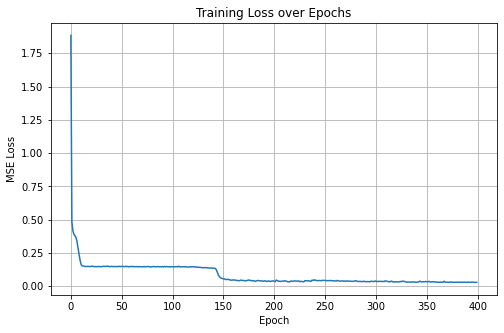

In [61]:

model = ResNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_hidden=num_hidden, activation = activation)

if not load_path:
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    if cross_entropy: 
        criterion = nn.BCEWithLogitsLoss()
    else: criterion = nn.MSELoss()

    print(criterion)
    # Training loop

    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            # print(outputs.size())
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        if (epoch+1) % 20 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}')
        losses.append(epoch_loss / len(dataloader))
        
# --- Save Checkpoint ---
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(), # Good practice to save optimizer state too
        'losses': losses,
        'seed': seed,
        'epoch': epoch, # Save the last epoch number
        'input_dim': input_dim, # Save hyperparameters for verification/reproducibility
        'hidden_dim': hidden_dim,
        'output_dim': output_dim,
        'num_blocks': num_hidden,
        'cross_entropy': cross_entropy
    }
    save_path = f'last.pth'
    torch.save(checkpoint, save_path)
    print(f'Checkpoint saved to {save_path}')
    # We have the losses from training directly
        


else:
    load_path = load_path + '.pth'
    try:
        print(f"--- Loading Checkpoint from: {load_path} ---")
        checkpoint = torch.load(load_path)

        # Load model state
        model.load_state_dict(checkpoint['model_state_dict'])

        # Load losses and seed from the checkpoint
        losses = checkpoint.get('losses', []) # Use .get for backward compatibility if 'losses' key is missing
        loaded_seed = checkpoint.get('seed', 'Not Found') # Use .get for backward compatibility

        # Optionally load optimizer state if you plan to resume training
        # optimizer = torch.optim.Adam(model.parameters()) # Re-initialize optimizer
        # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # start_epoch = checkpoint['epoch'] + 1 # To resume training

        # Load other saved info (optional, but good for verification)
        loaded_input_dim = checkpoint.get('input_dim', 'Not Found')
        loaded_hidden_dim = checkpoint.get('hidden_dim', 'Not Found')
        loaded_output_dim = checkpoint.get('output_dim', 'Not Found')
        loaded_num_blocks = checkpoint.get('num_blocks', 'Not Found')
        loaded_cross_entropy = checkpoint.get('cross_entropy', 'Not Found')
        last_epoch = checkpoint.get('epoch', 'Not Found')


        print(f"Model state loaded successfully.")
        print(f"Loaded training losses (Length: {len(losses)}).")
        print(f"Original training seed: {loaded_seed}")
        print(f"Model trained for {last_epoch + 1 if isinstance(last_epoch, int) else 'N/A'} epochs.")
        print(f"Saved Hyperparameters: Input={loaded_input_dim}, Hidden={loaded_hidden_dim}, Output={loaded_output_dim}, Blocks={loaded_num_blocks}, CrossEntropy={loaded_cross_entropy}")


        model.eval() # Set model to evaluation mode after loading
        print("Model set to evaluation mode.")

    except FileNotFoundError:
        print(f"Error: Checkpoint file not found at {load_path}")
        losses = [] # Ensure losses is an empty list if loading failed


# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()



In [62]:
model.parameters

<bound method Module.parameters of ResNet(
  (input_fc): Linear(in_features=2, out_features=2, bias=True)
  (activation): ReLU()
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (activation): ReLU()
    )
    (1): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (activation): ReLU()
    )
    (2): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (activation): ReLU()
    )
    (3): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (activation): ReLU()
    )
    (4): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (activation): ReLU()
    )
  )
  (output_fc): Linear(in_features=2, out_features=2, bias=True)
)>

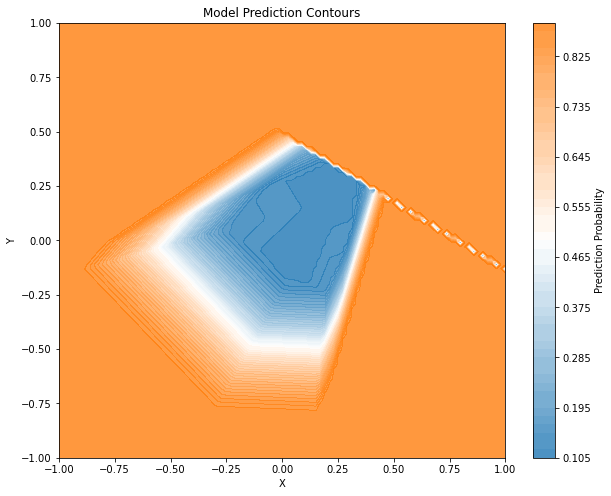

In [63]:
# Plot prediction contours
xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
with torch.no_grad():
    preds = model(grid)  # shape: (10000, 2)
    
    # Distance to each label vector
    dist_to_class1 = torch.norm(preds - torch.tensor([1.0, 0.0]), dim=1)
    dist_to_class2 = torch.norm(preds - torch.tensor([-1.0, 0.0]), dim=1)

    # Turn distance into "confidence"
    scores = torch.stack([-dist_to_class1, -dist_to_class2], dim=1)  # negative = closer is better
    probs = torch.softmax(scores, dim=1)

    zz = probs[:, 0].reshape(xx.shape).numpy()  # confidence of being class [1, 0]


colors = [to_rgb("C0"), [1, 1, 1], to_rgb("C1")] # first color is orange, last is blue
cm = LinearSegmentedColormap.from_list(
            "Custom", colors, N=40)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, zz, levels=50, cmap=cm, alpha=0.8)
plt.colorbar(label='Prediction Probability')
plt.xlabel('X')
plt.ylabel('Y')
# plt.scatter(ring_points[:500, 0], ring_points[:500, 1], s=25, facecolors='C1', edgecolors='black', linewidths=0.5, alpha=0.5)
# plt.scatter(inside_points[:500, 0], inside_points[:500, 1], s=25, c='C0',  edgecolors='black', linewidths=0.5, alpha=0.5,  label='Inside Points')
plt.title('Model Prediction Contours')
# plt.axis('equal')
plt.grid(False)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('tight')
plt.show()


# Singular value computations and plotting
We want to determine singular points in the compact space

In [64]:
# Define a grid over the input space.
grid_size = 200 # Adjust as needed.

def psi_manual(x, func):
    """
    x: a tensor of shape (2,) representing a point in R^2.
    model: a function mapping R^2 to R^2.
    
    Returns:
      The smallest singular value of the Jacobian of model at x.
    """
    # Ensure x is a leaf variable with gradient tracking enabled.
    x = x.clone().detach().requires_grad_(True)
    
    # Define a lambda function to ensure accurate input-output mapping
    # func = lambda inp: model(inp, output_layer = False)
    
    # Compute the Jacobian using torch.autograd.functional.jacobian (compatible with Python 3.8)
    jacobian = torch.autograd.functional.jacobian(func, x, create_graph=True)
    
    # Compute singular values using svdvals (available in PyTorch 1.8, compatible with Python 3.8)
    singular_values = torch.svd(jacobian, compute_uv=False)[1]
    
   
    return singular_values.detach().numpy()



x_range = np.linspace(-1, 1, grid_size)
y_range = np.linspace(-1, 1, grid_size)
psi_values = np.zeros((grid_size, grid_size, 2))

# Put the model in evaluation mode.
model.eval()
func = lambda inp: model(inp, output_layer = False)

# Evaluate psi(x) over the grid.
for i, xv in enumerate(x_range):
    for j, yv in enumerate(y_range):
        # Create a 2D point as a torch tensor.
        x_point = torch.tensor([xv, yv], dtype=torch.float32)
        psi_values[j, i,:] = psi_manual(x_point, func)

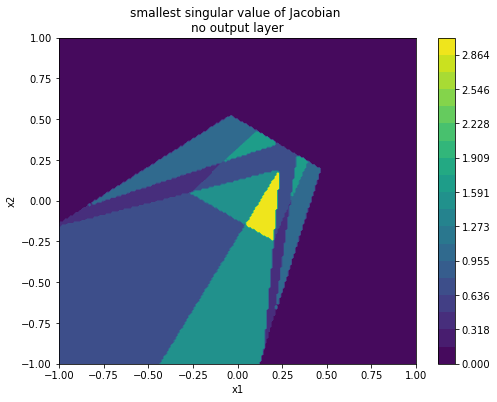

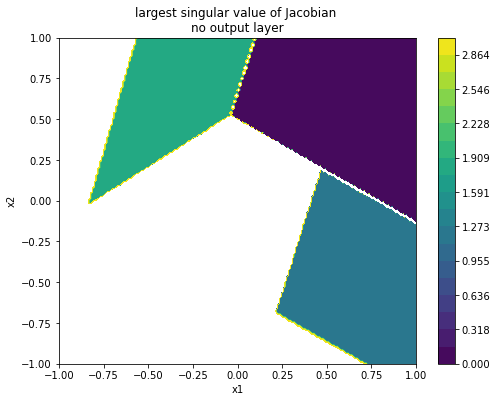

In [65]:

# Plot the contour corresponding to psi ~ 0.
plt.figure(figsize=(8, 6))
# Here we plot the contour at a small level, e.g., 0.01.
# CS = plt.contour(x_range, y_range, psi_values, levels=[0,0.05,0.1,0.2,0.3], colors='red')

# Define the number of levels for the contour plot
vmin, vmax = psi_values[:, :, 1].min(), psi_values[:, :, 1].max()
num_levels = 20
levels = np.linspace(0, vmax, num_levels)
# Create the contour plot using the 'binary' colormap
CS = plt.contourf(x_range, y_range, psi_values[:,:,1], levels=levels, cmap = 'viridis')
cbar = plt.colorbar(CS)
plt.title('smallest singular value of Jacobian \nno output layer')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Plot the contour corresponding to psi ~ 0.
plt.figure(figsize=(8, 6))
# Here we plot the contour at a small level, e.g., 0.01.
# CS = plt.contour(x_range, y_range, psi_values, levels=[0,0.05,0.1,0.2,0.3], colors='red')

# Define the number of levels for the contour plot


# Create the contour plot using the 'binary' colormap
CS = plt.contourf(x_range, y_range, psi_values[:,:,0], levels=levels, cmap = 'viridis')
cbar = plt.colorbar(CS)
plt.title('largest singular value of Jacobian \nno output layer')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()



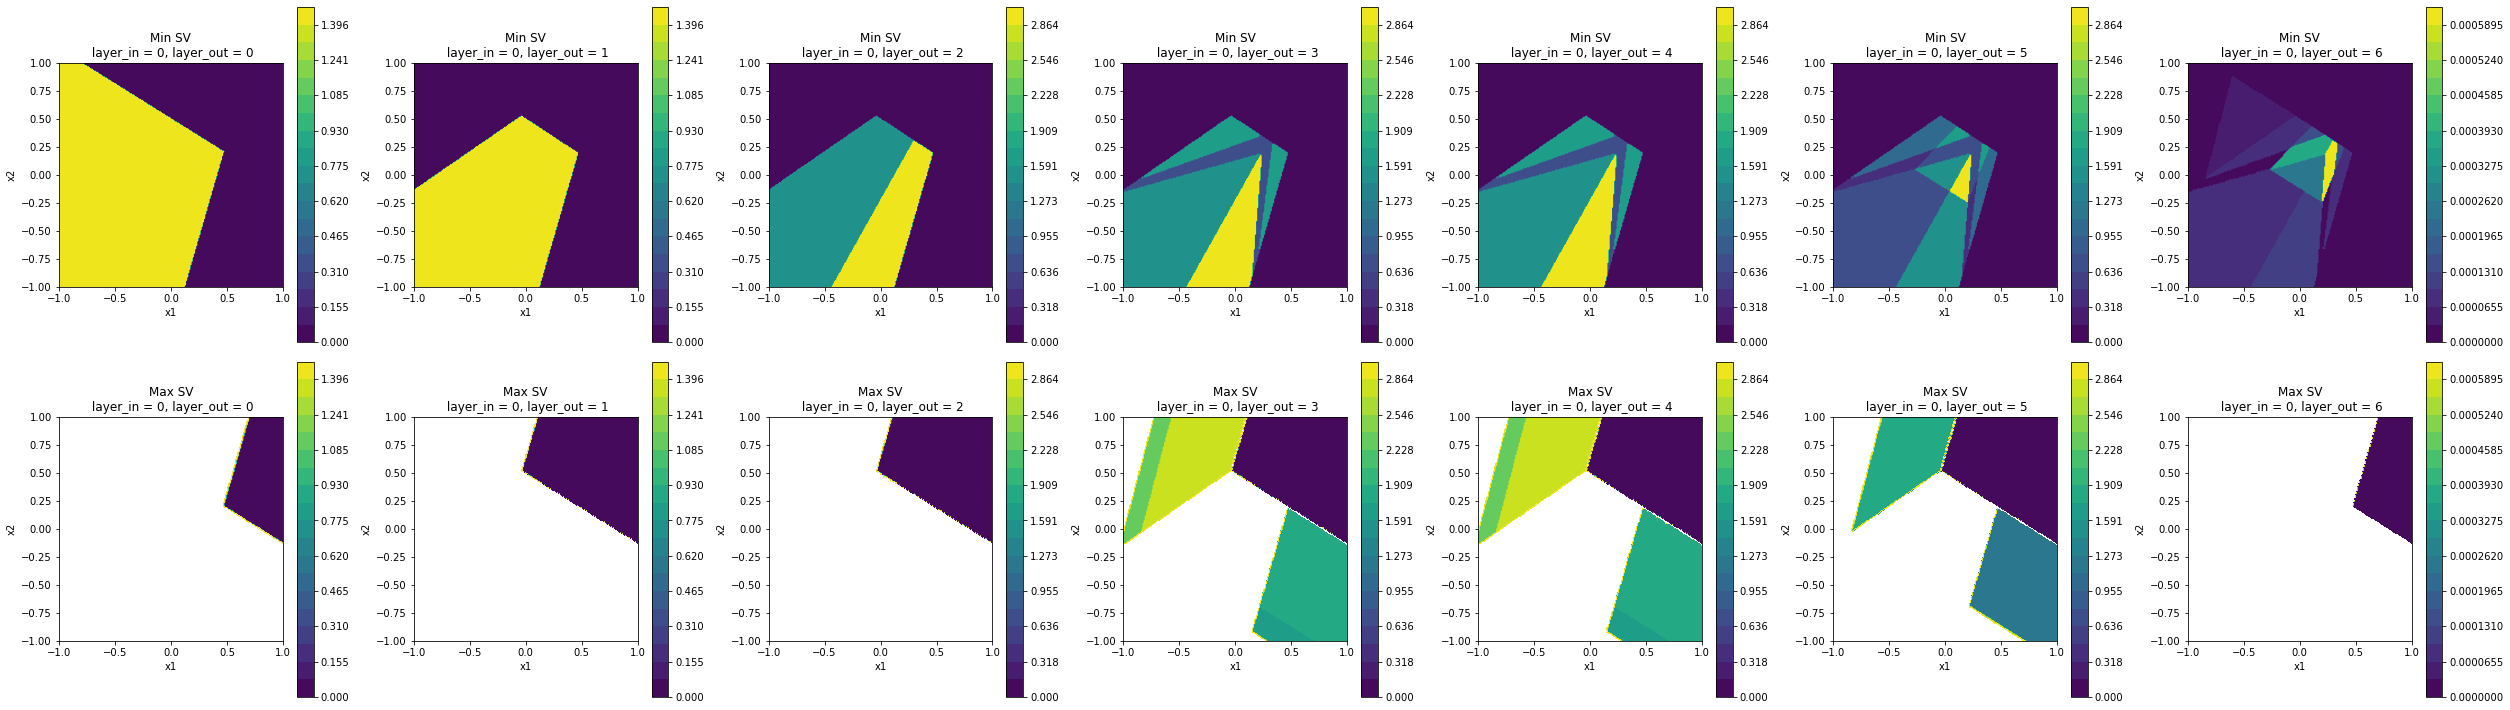

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Put the model in evaluation mode.
model.eval()

# Prepare figure and axes
fig, axes = plt.subplots(2, num_hidden + 2, figsize=(5 * (num_hidden + 2), 10))  # Adjust figsize if needed

for layer in range(num_hidden + 2):
    func = lambda inp: model.sub_model(inp, from_layer=0, to_layer = layer)

    # Evaluate psi(x) over the grid.
    for i, xv in enumerate(x_range):
        for j, yv in enumerate(y_range):
            x_point = torch.tensor([xv, yv], dtype=torch.float32)
            psi_values[j, i, :] = psi_manual(x_point, func)

    # Determine contour levels
    vmin, vmax = psi_values[:, :, 1].min(), psi_values[:, :, 1].max()
    num_levels_contour = 20
    levels = np.linspace(0, vmax, num_levels_contour)

    # Plot smallest singular value (index 1) - first row
    ax = axes[0, layer] if num_hidden > 1 else axes[0]
    cs = ax.contourf(x_range, y_range, psi_values[:, :, 1], levels=levels, cmap='viridis')
    fig.colorbar(cs, ax=ax)
    ax.set_title(f'Min SV\n layer_in = 0, layer_out = {layer}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')
    

    # Plot largest singular value (index 0) - second row
    ax = axes[1, layer] if num_hidden > 1 else axes[1]
    cs = ax.contourf(x_range, y_range, psi_values[:, :, 0], levels=levels, cmap='viridis')
    fig.colorbar(cs, ax=ax)
    ax.set_title(f'Max SV\n layer_in = 0, layer_out = {layer}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


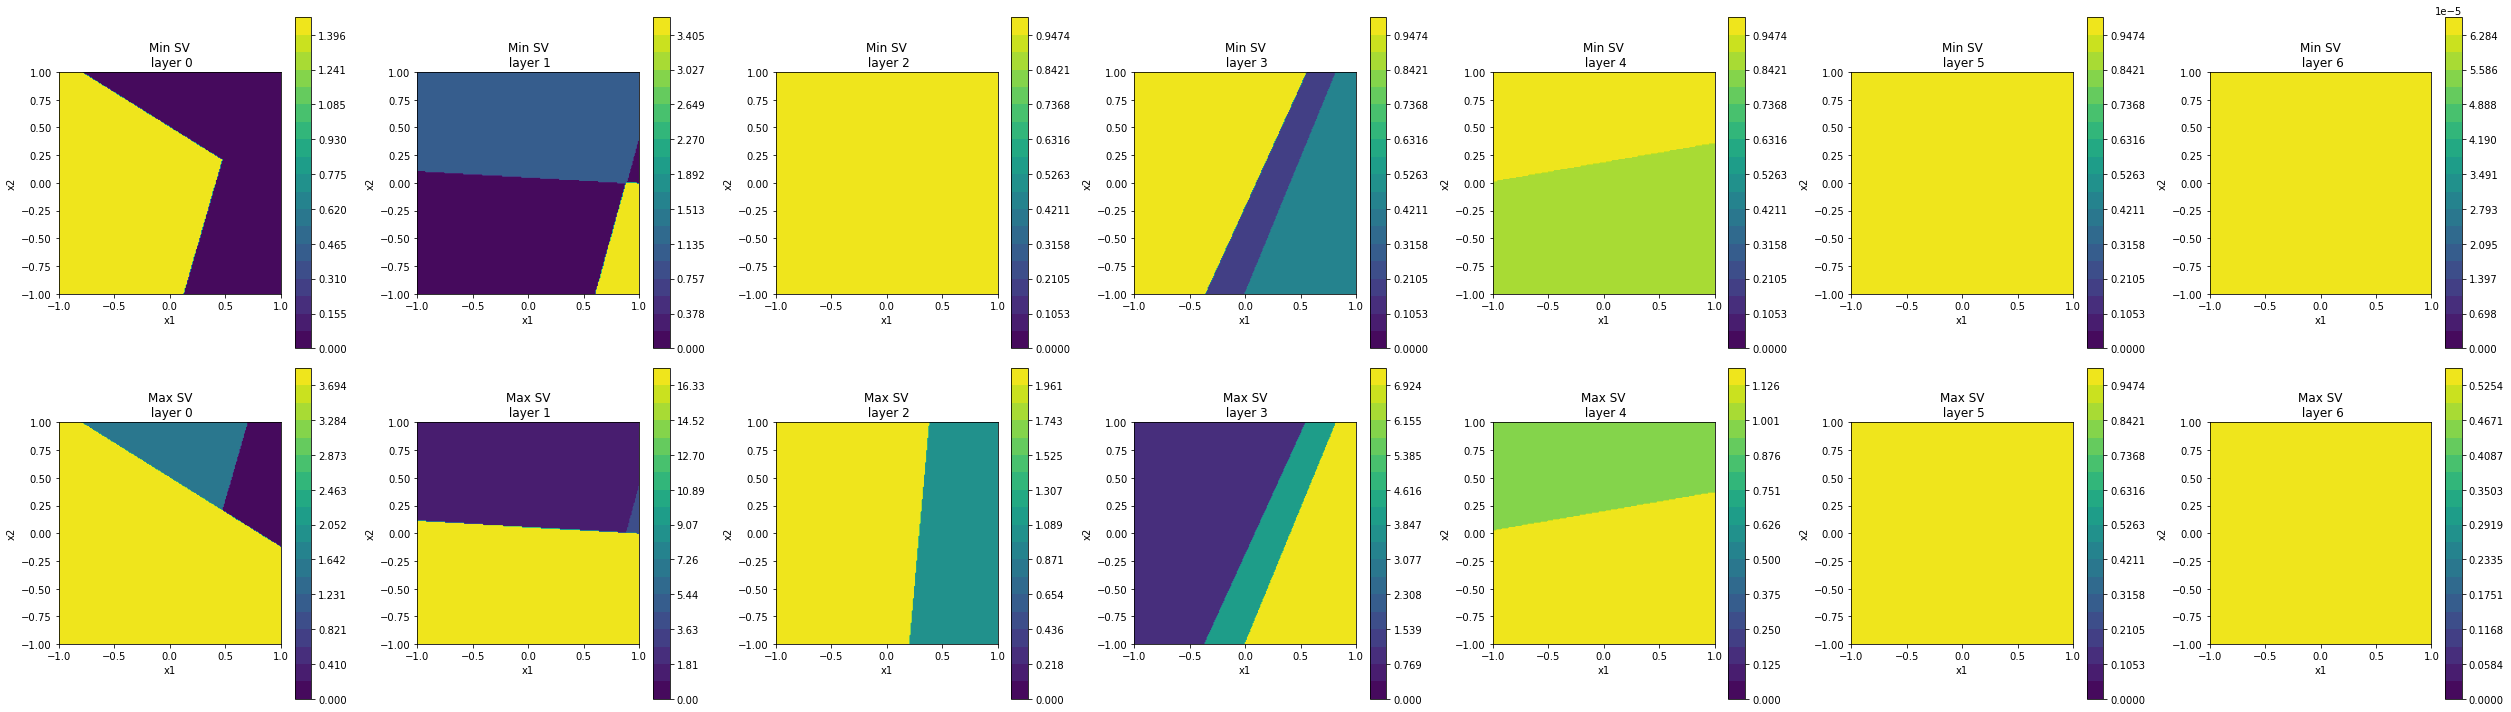

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Put the model in evaluation mode.
model.eval()

# Prepare figure and axes
fig, axes = plt.subplots(2, num_hidden + 2, figsize=(5 * (num_hidden + 2), 10))  # Adjust figsize if needed

for layer in range(num_hidden + 2):
    func = lambda inp: model.sub_model(inp, from_layer = layer, to_layer=layer)

    # Evaluate psi(x) over the grid.
    for i, xv in enumerate(x_range):
        for j, yv in enumerate(y_range):
            x_point = torch.tensor([xv, yv], dtype=torch.float32)
            psi_values[j, i, :] = psi_manual(x_point, func)

    # Determine contour levels
    vmin1, vmax1 = psi_values[:, :, 1].min(), psi_values[:, :, 1].max()
    num_levels_contour = 20
    levels1 = np.linspace(0, vmax1, num_levels_contour)

    # Plot smallest singular value (index 1) - first row
    ax = axes[0, layer] if num_hidden > 1 else axes[0]
    cs = ax.contourf(x_range, y_range, psi_values[:, :, 1], 
                     levels=levels1,
                     cmap='viridis')
    fig.colorbar(cs, ax=ax)
    ax.set_title(f'Min SV\n layer {layer}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')
    

    # Determine contour levels
    vmin0, vmax0 = psi_values[:, :, 0].min(), psi_values[:, :, 0].max()
    num_levels_contour = 20
    levels0 = np.linspace(0, vmax0, num_levels_contour)

    # Plot largest singular value (index 0) - second row
    ax = axes[1, layer] if num_hidden > 1 else axes[1]
    cs = ax.contourf(x_range, y_range, psi_values[:, :, 0],
                     levels=levels0, 
                     cmap='viridis')
    fig.colorbar(cs, ax=ax)
    ax.set_title(f'Max SV\n layer {layer}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()
